In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
# NOTE: PLEASE MAKE SURE YOU ARE RUNNING THIS IN A PYTHON3 ENVIRONMENT

import tensorflow as tf
print(tf.__version__)


2.0.0-alpha0


In [8]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [1]:
# If the import fails, run this
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


ModuleNotFoundError: No module named 'tensorflow_datasets'

In [2]:
train_data, test_data = imdb['train'], imdb['test']

NameError: name 'imdb' is not defined

In [3]:
tokenizer = info.features['text'].encoder

NameError: name 'info' is not defined

In [4]:
print(tokenizer.subwords)

NameError: name 'tokenizer' is not defined

In [9]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


**Note:** The tokenizer used in the following code is case sensitive and maintains punctuation. This is unlike the tokenizer we have been using so far.

In [10]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


**Note:** Trying to use Flatten() on the Embedding output will cause TensorFlow to crash! So we use GlobalAveragePooling instead.

In [11]:
embedding_dim = 64

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


**Note:** Use the following code to create batches to fit the data. Not sure why this is needed but model.fit() doesn't work without it.

In [12]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32,train_data.output_shapes))

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [13]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_batches, epochs=num_epochs, validation_data=test_batches, validation_steps=30)

Epoch 1/10
782/782 [==============================] - 15s 19ms/step - loss: 0.6490 - accuracy: 0.6495 - val_loss: 0.5485 - val_accuracy: 0.7979
Epoch 2/10
782/782 [==============================] - 15s 19ms/step - loss: 0.3938 - accuracy: 0.8645 - val_loss: 0.3744 - val_accuracy: 0.8594
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2821 - accuracy: 0.8994 - val_loss: 0.3456 - val_accuracy: 0.8677
Epoch 4/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2405 - accuracy: 0.9138 - val_loss: 0.3428 - val_accuracy: 0.8677
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2158 - accuracy: 0.9226 - val_loss: 0.3384 - val_accuracy: 0.8719
Epoch 6/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1922 - accuracy: 0.9303 - val_loss: 0.3514 - val_accuracy: 0.8729
Epoch 7/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1766 - accuracy: 0.9386 - val_loss: 0.3567 - val_accuracy:

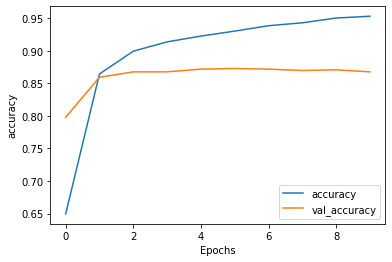

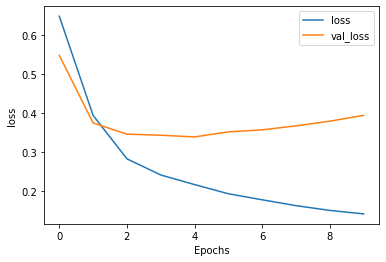

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Note:** The low accuracy can be attributed to the fact that subwords have nonsensical meaning by themselves and so it's hard to extract meaning from them. Sequences of subwords have meaning, so analyzing subwords in sequences is what we will focus on next week with RNNs.

In [15]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

(8185, 64)
